# Exploration of spaCy and NLP

* Splitting sentences based on conjunctions, adverbial clauses, etc.
* Using a dependency parse to get the 'gist' of a sentence and then create a 'narrative timeline'

Note that this notebook is just a set of attempts to understand what spaCy and/or supporting libraries were 'doing'. And, used both the en_core_web_lg and en_core_web_trf models.

In [2]:
# Imports and set up
import copy
import spacy
from spacy.matcher import DependencyMatcher
from spacy.tokens import Doc, Span, Token
import pandas as pd

nlp = spacy.load('en_core_web_trf')
nlp.add_pipe('sentencizer')

In [3]:
# Test sentence clause parsing
texts = ["Mary walked to the store.",
        "Mary walked and biked to the store.",
        "Mary and John walked to the store.", 
        "Mary and John biked and walked to the store.",
        "Mary biked and John walked to the store.",
        "Mary walked to the store and John walked to the store.",
        "Mary biked to the store and John walked to the store.",
        "Mary biked to the market and John walked to the store.",
        "After escaping to the Soviet Union, I and Beatrice returned to Czechoslovakia after World War II, where they were eventually reunited with their parents."]

def get_chunks(verb: Token, connector: list, sentence: Span, is_conj: bool) -> list:
        chunks = []
        seen = set()
        subj2 = [subj for subj in verb.children if 'subj' in subj.dep_]
        if len(subj2) == 1:
            # Separate clause
            words = [ww for ww in verb.subtree if ww.pos_ != 'PUNCT']
            for word in words:
                seen.add(word)
            seen_chunk = ' '.join([ww.text for ww in words])
            unseen = [ww for ww in sentence if ww not in seen and ww.pos_ != 'PUNCT']
            unseen_chunk = ' '.join([ww.text for ww in unseen])
            if is_conj:
                for conn in connector:
                    unseen_chunk = unseen_chunk.replace(f' {conn.text}', '')
            else:
                for conn in connector:
                    seen_chunk = seen_chunk.replace(f' {conn.text}', '')
                    seen_chunk = seen_chunk.replace(conn.text, '')
            chunks.append(unseen_chunk.strip() + '.')
            chunks.append(seen_chunk.strip() + '.')
        if len(chunks) > 0:
            return chunks
        else:
            return [sentence.text]
    
for text in texts:
    doc = nlp(text)
    for sent in doc.sents:
        print(sent)
        orig_sents = [sent.text]
        while True:
            new_sents = []
            for orig_sent in orig_sents:
                chunk_doc = nlp(orig_sent)
                for chunk_sent in chunk_doc.sents:
                    conj_verb = [child for child in chunk_sent.root.children if child.dep_ == 'conj']
                    connector = [conn for conn in chunk_sent.root.children if conn.dep_ == 'cc']
                    if len(conj_verb) > 0:
                        intermed_sents = get_chunks(conj_verb[0], connector, chunk_sent, True)
                    else:
                        intermed_sents = [orig_sent]
                    for intermed_sent in intermed_sents:
                        chunk_doc2 = nlp(intermed_sent)
                        for chunk_sent2 in chunk_doc2.sents:
                            advcl_verb = [child for child in chunk_sent2.root.children if child.dep_ == 'advcl']
                            if len(advcl_verb) > 0:
                                connector = [conn for conn in advcl_verb[0].children if conn.dep_ == 'advmod']
                            else:
                                connector = []
                            if len(advcl_verb) > 0 and len(connector) > 0:
                                for chunk in get_chunks(advcl_verb[0], connector, chunk_sent2, False):
                                      new_sents.append(chunk) 
                            else:
                                new_sents.append(intermed_sent)
            if len(orig_sents) == len(new_sents):
                break
            else:
                orig_sents = copy.deepcopy(new_sents)
                
    print(new_sents)

Mary walked to the store.
['Mary walked to the store.']
Mary walked and biked to the store.
['Mary walked and biked to the store.']
Mary and John walked to the store.
['Mary and John walked to the store.']
Mary and John biked and walked to the store.
['Mary and John biked and walked to the store.']
Mary biked and John walked to the store.
['Mary biked.', 'John walked to the store.']
Mary walked to the store and John walked to the store.
['Mary walked to the store.', 'John walked to the store.']
Mary biked to the store and John walked to the store.
['Mary biked to the store.', 'John walked to the store.']
Mary biked to the market and John walked to the store.
['Mary biked to the market.', 'John walked to the store.']
After escaping to the Soviet Union, I and Beatrice returned to Czechoslovakia after World War II, where they were eventually reunited with their parents.
['After escaping to the Soviet Union I and Beatrice returned to Czechoslovakia after World War II.', 'they were reunited

In [34]:
narrative = "I was born on June 12, 1928, in Znojmo, a town in the Moravian region of Czechoslovakia with a Jewish community dating back to the thirteenth century. My father was a respected attorney and an ardent Zionist who hoped to emigrate with his family to Palestine. In 1931, my family moved to Stanesti, a town in the Romanian province of Bukovina, where my paternal grandparents lived. \n\nIn Stanesti, I attended the public school as well as the Hebrew school, which my father had helped found. I loved to play with my sister Beatrice and the other children in the town and enjoyed being with my grandfather. My childhood was filled with hopes and dreams for the future. In 1937, however, members of the fascist Iron Guard tried to remove my father from his position as the chief civil official in Stanesti. Eventually, a court cleared him of the fabricated charges and he was restored to his post. \n\nIn 1940, the Soviet Union occupied Bukovina. A year later, when Romania joined Nazi Germany in the war against the Soviet Union, the Soviets were driven from Stanesti. Mobs then carried out bloody attacks on the town's Jews. During the violence, I and my family fled to Czernowitz with the aid of the local police chief. In fall of 1941, my family were forced to settle in the Czernowitz ghetto, where living conditions were poor and they were subject to deportation to Transnistria. In 1943, I and Beatrice escaped from the ghetto using false papers that their father had obtained. After escaping to the Soviet Union, I and Beatrice returned to Czechoslovakia after World War II, where they were eventually reunited with their parents. \n\nI married an officer in the Czech army and raised two children. After many years of hard effort and my mother and sister's appeals to Soviet leader Nikita Khrushchev, I was permitted to emigrate from Czechoslovakia to the United States in 1960, three years after the death of my husband. Once in the United States, I became a supervisor of a pathology lab. "

In [5]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

excluded_stopwords = ['she', 'he', 'they', 'you', 'us', 'him', 'her', 
                      'them', 'himself', 'herself', 'themselves', 'yourself', 
                      'yourselves', 'ourselves']
nlp.Defaults.stop_words -= set(excluded_stopwords)

unwanted_tokens = (
    'ADV',    # adverb
    'PART',   # particle
    'DET',    # determiner
    'INTJ',   # interjection
    'SCONJ',  # subordinating conjunction
    'PUNCT',  # punctuation
    'SYM',    # symbol
    'X',      # other
)


In [40]:
def add_to_dictionary_values(dictionary: dict, key: str, value, value_type):
    """
    Add the value for the specified key in the dictionary or create a dictionary entry for that key
    (where the value is a list).

    :param dictionary: The dictionary to be updated
    :param key: String holding the dictionary key
    :param value: The value to be added to the current list of values of the dictionary entry, or
                  a new list is created with the value
    :param value_type: The python "type" (e.g., str, int, dict, list, ...)
    :return: None
    """
    values = []
    if key in dictionary.keys():
        values = dictionary[key]
    values.append(value_type(value))
    dictionary[key] = values
    return

def handle_conjunctions(sentence: Span) -> list:
    """
    Split the clauses of a sentence into separate sentences, if warranted. For example, 
    "Mary and John walked to the store." would not be split, but "Mary biked to the store 
    and John walked to the store." would be split.
    
    :param sentence The sentence which is analyzed.
    :return: An array of simpler sentence(s) to be parsed. Only the text of the sentences
             is returned, not the spacy tokens.
    """
    orig_sents = [sentence.text]
    
    while True:
        new_sents = []
        for orig_sent in orig_sents:
            chunk_doc = nlp(orig_sent)
            for chunk_sent in chunk_doc.sents:
                conj_verb = [child for child in chunk_sent.root.children if child.dep_ == 'conj']
                connector = [conn for conn in chunk_sent.root.children if conn.dep_ == 'cc']
                if len(conj_verb) > 0:
                    intermed_sents = get_chunks(conj_verb[0], connector, chunk_sent, True)
                else:
                    intermed_sents = [orig_sent]
                for intermed_sent in intermed_sents:
                    chunk_doc2 = nlp(intermed_sent)
                    for chunk_sent2 in chunk_doc2.sents:
                        advcl_verb = [child for child in chunk_sent2.root.children if child.dep_ == 'advcl']
                        if len(advcl_verb) > 0:
                            connector = [conn for conn in advcl_verb[0].children if conn.dep_ == 'advmod']
                        else:
                            connector = []
                        if len(advcl_verb) > 0 and len(connector) > 0:
                            for chunk in get_chunks(advcl_verb[0], connector, chunk_sent2, False):
                                  new_sents.append(chunk) 
                        else:
                            new_sents.append(intermed_sent)
        if len(orig_sents) == len(new_sents):
            break
        else:
            orig_sents = copy.deepcopy(new_sents)
    
    return new_sents

In [156]:
def add_token_details(token: Token, dictionary: dict, key: str):
    """
    Simplify the token text, specify an entity type (if not already defined), and 
    add the token details to the specified dictionary key.

    :param token
    :param dictionary
    :param key
    :param token_type
    :return None
    """
    ent_type = token.ent_type_
    if token.text == 'I':
        ent = 'I'
        ent_type = 'NARRATOR'
    elif 'verb' in key:
        ent = token.text
        ent_type = 'VERB'
    elif token.text.lower() in excluded_stopwords:
        ent = token.text
        ent_type = 'PERSON'
    else:
        # Simplify the entity text for nouns
        ent = ' '.join(str(t.text) for t in nlp(token.text) if (t.pos_ not in unwanted_tokens and not t.is_stop))
        if ent_type == '':
            ent_type = 'NOUN'
            
    # Set up the entity's dictionary and basic details
    ent_dict = dict()
    ent_dict[f'{key[0:-1] if key.endswith("s") else key}_text'] = ent
    if 'verb' in key:
        ent_dict[f'{key}_lemma'] = token.lemma_
    else:    
        ent_dict[f'{key[0:-1] if key.endswith("s") else key}_type'] = ent_type
        
    # Process specific children (conjunctions and prepositions)
    for child in token.children:
        if ent_type == 'VERB' and ('obj' in child.dep_ or 'attr' in child.dep_):
            if 'advcl' in key:
                add_token_details(child, ent_dict, 'objects')
            else:
                add_token_details(child, dictionary, 'objects')
        elif 'conj' in child.dep_:
            add_token_details(child, dictionary, key)
        elif 'prep' in child.dep_:
            prep_dict = dict()
            # Lists of dictionaries have plural names while individual dictionary keys should not
            prep_dict[f'{key[0:-1] if key.endswith("s") else key}_prep_text'] = child.text
            for prep_child in child.children:
                if 'obj' in prep_child.dep_ or 'attr' in prep_child.dep_: 
                    process_prep_object(prep_child, prep_dict, (key[0:-1] if key.endswith("s") else key))
                    # Are there multiple objects (i.e., a conjunction)?
                    # TODO: Only gets 1 other conjunctive
                    for child_squared in prep_child.children:
                        if 'conj' == child_squared.dep_:
                            process_prep_object(child_squared, prep_dict, (key[0:-1] if key.endswith("s") else key))
            add_to_dictionary_values(ent_dict, f'{key[0:-1] if key.endswith("s") else key}_preps', prep_dict, dict)
    add_to_dictionary_values(dictionary, key, ent_dict, dict)
    return

def process_prep_object(token, dictionary, key):
    prep_ent = ' '.join(str(t.text) for t in nlp(token.text) if (t.pos_ not in unwanted_tokens and not t.is_stop))
    prep_ent_type = token.ent_type_
    if prep_ent_type == '':
        prep_ent_type = 'NOUN' 
    prep_ent_detail = dict()
    prep_ent_detail[f'{key[0:-1] if key.endswith("s") else key}_prep_object'] = prep_ent
    prep_ent_detail[f'{key[0:-1] if key.endswith("s") else key}_prep_object_type'] = prep_ent_type
    add_to_dictionary_values(dictionary, f'{key}_prep_objects', prep_ent_detail, dict)
    

def process_verb(token, dictionary):
    ent = token.text
    verb_dict = dict()
    verb_dict['verb_text'] = ent
    verb_dict['verb_lemma'] = token.lemma_
    for child in token.children:
        if 'aux' == child.dep_:
            add_token_details(child, verb_dict, 'verb_aux')
        if 'advcl' == child.dep_:
            add_token_details(child, verb_dict, 'verb_advcl')
        elif 'xcomp' == child.dep_:
            add_token_details(child, verb_dict, 'verb_xcomp')
        elif 'conj' == child.dep_:
            process_verb(child, dictionary)
        elif 'subj' in child.dep_:
            add_token_details(child, dictionary, 'subjects')  
        elif 'obj' in child.dep_ or 'attr' in child.dep_:
            add_token_details(child, verb_dict, 'objects')
        elif 'prep' in child.dep_:
            prep_dict = dict()
            prep_dict['prep_text'] = child.text
            for prep_dep in child.children:
                add_token_details(prep_dep, prep_dict, 'prep_details')
            add_to_dictionary_values(verb_dict, 'preps', prep_dict, dict)
    add_to_dictionary_values(dictionary, 'verbs', verb_dict, dict)

In [157]:
doc = nlp(narrative)
sentences = []
for sentence in doc.sents:
    if sentence.text.startswith('\n'):
        continue
    print(sentence)
    # Change conjunctions into new sentences
    for sent in handle_conjunctions(sentence):
        nlp_sent = nlp(sent)
        # Determine the spans of individual nouns and noun chunks
        spans = list(nlp_sent.ents) + list(nlp_sent.noun_chunks)  
        spans = spacy.util.filter_spans(spans)
        # Reset the sentence parse to maintain chunks
        with nlp_sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                            'dep': span.root.dep}) for span in spans]
        # Store info starting from the ROOT verb
        sentence_dict = dict()
        for token in nlp_sent:
            if token.dep_ == 'ROOT':
                process_verb(token, sentence_dict)
        sentences.append(sentence_dict)
        print(sentence_dict)
    print()


I was born on June 12, 1928, in Znojmo, a town in the Moravian region of Czechoslovakia with a Jewish community dating back to the thirteenth century.
{'subjects': [{'subject_text': 'I', 'subject_type': 'NARRATOR'}], 'verbs': [{'verb_text': 'born', 'verb_lemma': 'bear', 'preps': [{'prep_text': 'on', 'prep_details': [{'prep_detail_text': 'June 12 1928', 'prep_detail_type': 'DATE'}]}, {'prep_text': 'in', 'prep_details': [{'prep_detail_text': 'Znojmo', 'prep_detail_type': 'GPE'}]}]}]}

My father was a respected attorney and an ardent Zionist who hoped to emigrate with his family to Palestine.
{'subjects': [{'subject_text': 'father', 'subject_type': 'NOUN'}], 'verbs': [{'verb_text': 'was', 'verb_lemma': 'be', 'objects': [{'object_text': 'ardent Zionist', 'object_type': 'NORP'}, {'object_text': 'respected attorney', 'object_type': 'NOUN'}]}]}

In 1931, my family moved to Stanesti, a town in the Romanian province of Bukovina, where my paternal grandparents lived.
{'subjects': [{'subject_text

{'subjects': [{'subject_text': 'Beatrice', 'subject_type': 'PERSON'}, {'subject_text': 'I', 'subject_type': 'NARRATOR'}], 'verbs': [{'verb_text': 'returned', 'verb_lemma': 'return', 'preps': [{'prep_text': 'After', 'prep_details': [{'prep_detail_text': 'escaping', 'prep_detail_type': 'NOUN', 'prep_detail_preps': [{'prep_detail_prep_text': 'to', 'prep_detail_prep_objects': [{'prep_detail_prep_object': 'Soviet Union', 'prep_detail_prep_object_type': 'GPE'}]}]}]}, {'prep_text': 'to', 'prep_details': [{'prep_detail_text': 'Czechoslovakia', 'prep_detail_type': 'GPE'}]}, {'prep_text': 'after', 'prep_details': [{'prep_detail_text': 'World War II', 'prep_detail_type': 'EVENT'}]}]}]}
{'subjects': [{'subject_text': 'they', 'subject_type': 'PERSON'}], 'verbs': [{'verb_text': 'reunited', 'verb_lemma': 'reunite', 'preps': [{'prep_text': 'with', 'prep_details': [{'prep_detail_text': 'parents', 'prep_detail_type': 'NOUN'}]}]}]}

I married an officer in the Czech army and raised two children.
{'subjec

In [158]:
current_date = ''
current_loc = ''
key_date = ''
orig_dates = set()
date_text_dict = dict()
for sent_dict in sentences:
    subjects = []
    for subject_dict in sent_dict['subjects']:
        subject_text = subject_dict['subject_text']
        if 'subject_preps' in subject_dict.keys():
            for subject_prep_dict in subject_dict['subject_preps']:
                subject_text += ' ' + subject_prep_dict['subject_prep_text'] 
                for subject_prep_obj_dict in subject_prep_dict['subject_prep_objects']:
                    subject_text += ' ' + subject_prep_obj_dict['subject_prep_object']
        subjects.append(subject_text)
    for verb_dict in sent_dict['verbs']:
        verb_text = verb_dict['verb_text']
        if 'preps' in verb_dict.keys():
            for prep_dict in verb_dict['preps']:
                prep_text = prep_dict['prep_text']
                count = 0
                for prep_detail_dict in prep_dict['prep_details']:
                    prep_type = prep_detail_dict['prep_detail_type']
                    if prep_text.lower() in ('in', 'on') and prep_type == 'DATE':
                        current_date = prep_detail_dict['prep_detail_text']
                    elif prep_text.lower() == 'after' and prep_type == 'EVENT' and prep_detail_dict['prep_detail_text'] == 'World War II':
                         # TODO Look up event date and signal 'After' that date
                        current_date = '1945'
                    elif prep_text.lower() in ('in', 'to', 'from') and \
                        (prep_type in ('GPE', 'LOC') or 'ghetto' in prep_detail_dict['prep_detail_text']):
                        current_loc = prep_detail_dict['prep_detail_text']
                    else: 
                        count += 1
                        if prep_text.lower() in verb_text:
                            space = ' '
                            if count > 1:
                                space = ', '
                            verb_text += space + prep_detail_dict['prep_detail_text']
                        else:
                            verb_text += ' ' + prep_text.lower() + ' ' + prep_detail_dict['prep_detail_text']
                    # TODO with aid of 
        if 'verb_aux' in verb_dict.keys():
            for verb_aux_dict in verb_dict['verb_aux']:
                verb_text = verb_aux_dict['verb_aux_text'] + ' ' + verb_text
                # TODO: 'verb_aux_preps' in verb_aux_dict.keys() ?
        if 'verb_xcomp' in verb_dict.keys():
            for verb_xcomp_dict in verb_dict['verb_xcomp']:
                verb_text += ' ' + verb_xcomp_dict['verb_xcomp_text']
                if 'verb_xcomp_preps' in verb_xcomp_dict.keys(): 
                    prep_objects = []
                    for prep_dict in verb_xcomp_dict['verb_xcomp_preps']:
                        prep_text = prep_dict['verb_xcomp_prep_text'] 
                        verb_text += ' ' + prep_text
                        if 'verb_xcomp_prep_objects' in prep_dict.keys():
                            for prep_object_dict in prep_dict['verb_xcomp_prep_objects']:
                                prep_object = prep_object_dict['verb_xcomp_prep_object']
                                prep_type = prep_object_dict['verb_xcomp_prep_object_type']
                                if prep_text.lower() in ('in', 'on') and prep_type == 'DATE':
                                    current_date = prep_object
                                elif prep_text.lower() == 'after' and prep_type == 'EVENT' and prep_object == 'World War II':
                                    # TODO Look up event date and signal 'After' that date
                                    current_date = '1945'
                                elif prep_text.lower() in ('in', 'to', 'from') and \
                                    (prep_type in ('GPE', 'LOC') or 'ghetto' in prep_object):
                                    current_loc = prep_object
                                else:
                                    prep_objects.append(prep_object)
                    if prep_objects:
                        verb_text += ' ' + ', '.join(prep_objects)
        objects = []
        if 'objects' in verb_dict.keys():
            for object_dict in verb_dict['objects']:
                object_text = object_dict['object_text']
                if 'object_preps' in object_dict.keys():  
                    for prep_dict in object_dict['object_preps']:   # TODO plural consistency
                        object_text += ' ' + prep_dict['object_prep_text']
                        for prep_detail in prep_dict['object_prep_objects']:
                             object_text += ' ' + prep_detail['object_prep_object']
                objects.append(object_text)
                
        print(f'Subjects: {", ".join(subjects)}')
        print(f'Verbs: {verb_text}')
        if objects:
            print(f'Objects: {", ".join(objects)}')
        print(f'Date: {current_date} and Loc: {current_loc}')
        date_texts = current_date.split(' ')
        for date_text in date_texts:
            if date_text.isnumeric() and int(date_text) > 1000:
                orig_dates.add(date_text)
            key_date = date_text
        text = f'Loc: {current_loc}\n'
        if not (len(subjects) == 1 and subjects[0] == 'I'):
            text += ', '.join(subjects) + ' ' + verb_text
        else:   
            text += verb_text
        if objects:
            text += ' ' + ', '.join(objects)
        final_text = text[0:100] + '\n'
        add_to_dictionary_values(date_text_dict, key_date, final_text, str)
        print()
                        

Subjects: I
Verbs: born
Date: June 12 1928 and Loc: Znojmo

Subjects: father
Verbs: was
Objects: ardent Zionist, respected attorney
Date: June 12 1928 and Loc: Znojmo

Subjects: family
Verbs: moved
Date: 1931 and Loc: Stanesti

Subjects: I
Verbs: attended
Objects: Hebrew school, public school
Date: 1931 and Loc: Stanesti

Subjects: I
Verbs: enjoyed being with grandfather
Date: 1931 and Loc: Stanesti

Subjects: I
Verbs: loved play with sister, children
Date: 1931 and Loc: Stanesti

Subjects: childhood
Verbs: filled with dreams, hopes
Date: 1931 and Loc: Stanesti

Subjects: members of fascist Iron Guard
Verbs: tried remove from position
Objects: father
Date: 1937 and Loc: Stanesti

Subjects: court
Verbs: cleared of fabricated charges
Objects: him
Date: 1937 and Loc: Stanesti

Subjects: he
Verbs: restored post
Date: 1937 and Loc: Stanesti

Subjects: Soviet Union
Verbs: occupied
Objects: Bukovina
Date: 1940 and Loc: Stanesti

Subjects: Soviets
Verbs: driven
Date: 1940 and Loc: Stanesti

Su

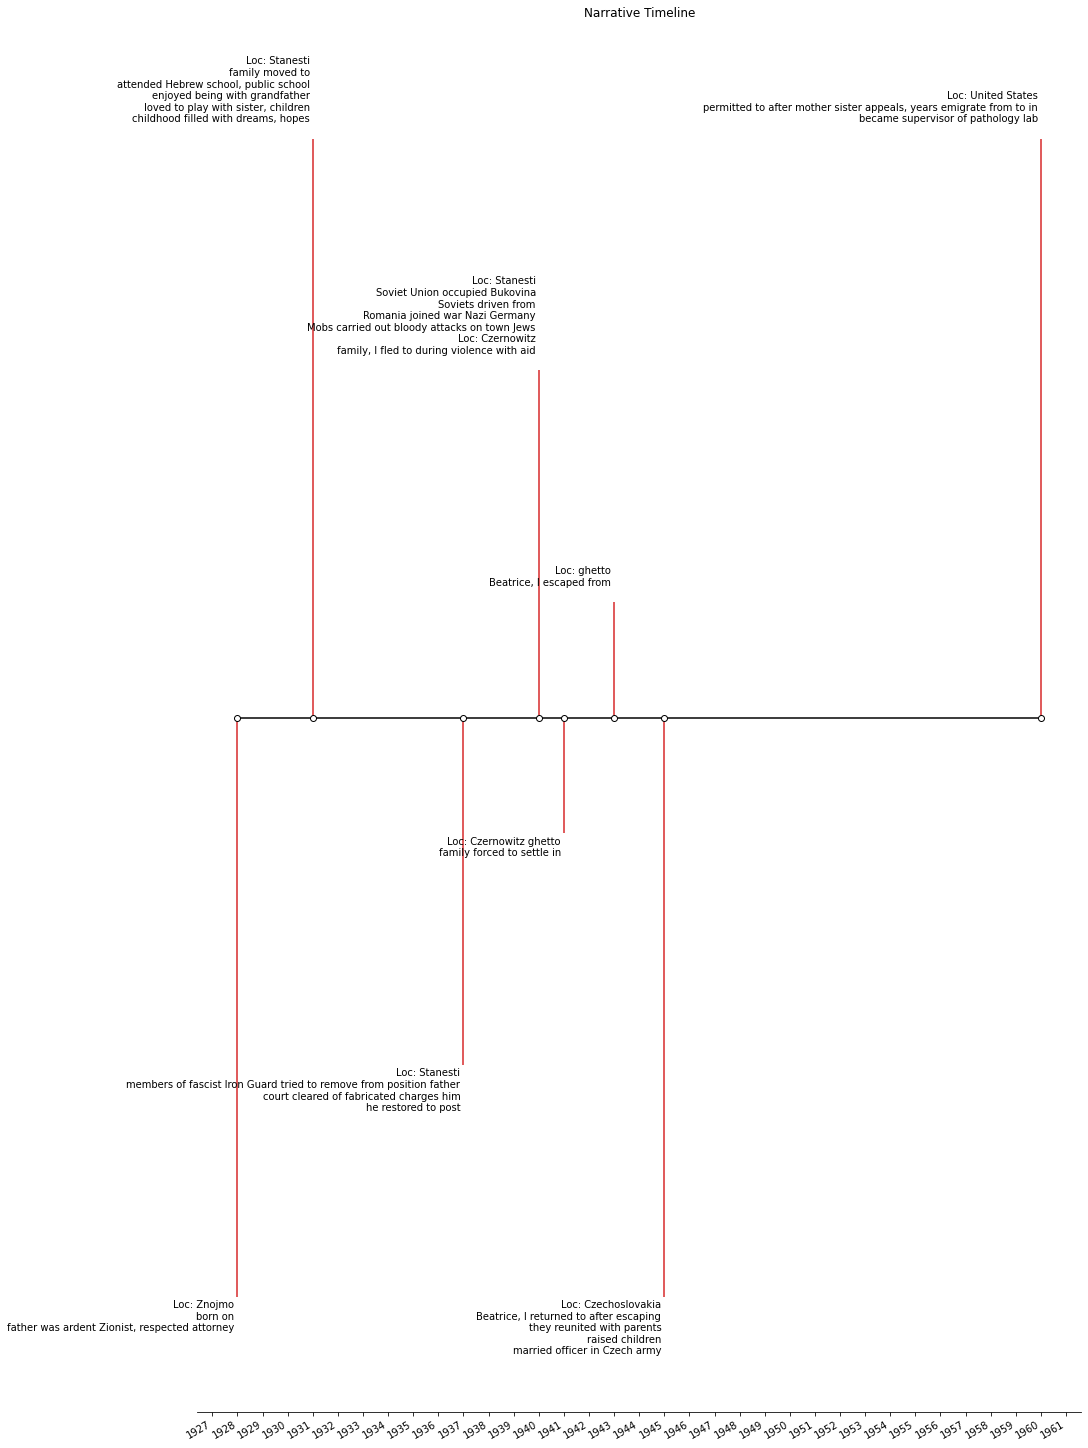

In [155]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

# TODO: No dates?
orig_dates = sorted(orig_dates)
names = []
for orig_date in orig_dates:
    date_text = ''
    loc_text = date_text_dict[orig_date][0].split('Loc: ')[1].split('\n')[0]
    for text in date_text_dict[orig_date]:
        text = text.replace(f'Loc: {loc_text}\n', '')
        date_text += text
    names.append(f'Loc: {loc_text}\n{date_text}')
dates = [datetime.strptime(d, "%Y") for d in orig_dates]

# Create a stem plot with some variation in levels as to distinguish even close-by events.
# Add markers on the baseline for visual emphasis on the one-dimensional nature of the time line.
# For each event, we add a text label via annotate, which is offset in units of points from the tip of the event line.

# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(15, 20), constrained_layout=True)
ax.set(title="Narrative Timeline")

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")       # Baseline and markers on it

# Annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

# Format xaxis with yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()